<a href="https://colab.research.google.com/github/Blutronics/MultipleRegression/blob/main/Black_Friday_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
import pylab
import statsmodels.formula.api as smf # for regression model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=527628451c48ca19a6a527ccb5ddfbada021c9ce935c759438050a41de2a0158
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.2 MB/s 


Female = 0 | Male = 1

City Category A = 0 | City Category B = 1 | City Category C = 2

In [2]:
df=pd.read_csv("blackfriday_train.csv")
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [4]:
df.shape

(550068, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [6]:
df.Product_Category_2.value_counts()

8.0     64088
14.0    55108
2.0     49217
16.0    43255
15.0    37855
5.0     26235
4.0     25677
6.0     16466
11.0    14134
17.0    13320
13.0    10531
9.0      5693
12.0     5528
10.0     3043
3.0      2884
18.0     2770
7.0       626
Name: Product_Category_2, dtype: int64

In [7]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


## **EDA**

droppDuppiesDf eliminates duplicate userID's. Of coarse this will only be useful for EDA, speiciafly for columns like Age, Occupation Ect. It also takes a minutes to run, just fyi.

In [8]:
droppDuppies = []
tempInstances =[]
for index, row in df.iterrows():
    # print(row['User_ID'])
    if row['User_ID'] not in tempInstances:
      tempInstances.append(row['User_ID'])
      droppDuppies.append(row)
 

In [9]:
droppDuppiesDf = pd.DataFrame(droppDuppies)

I had to creat these temp variables 'AgeInterval' and 'afAgeConts' since the order of the intervals was not in accending order

In [10]:
ageInterval = ['0-17','18-25','26-35','36-45','46-50','51-55','55+']

In [11]:
dfAgeCounts = [218,1069,2053,1167,531,481,372]

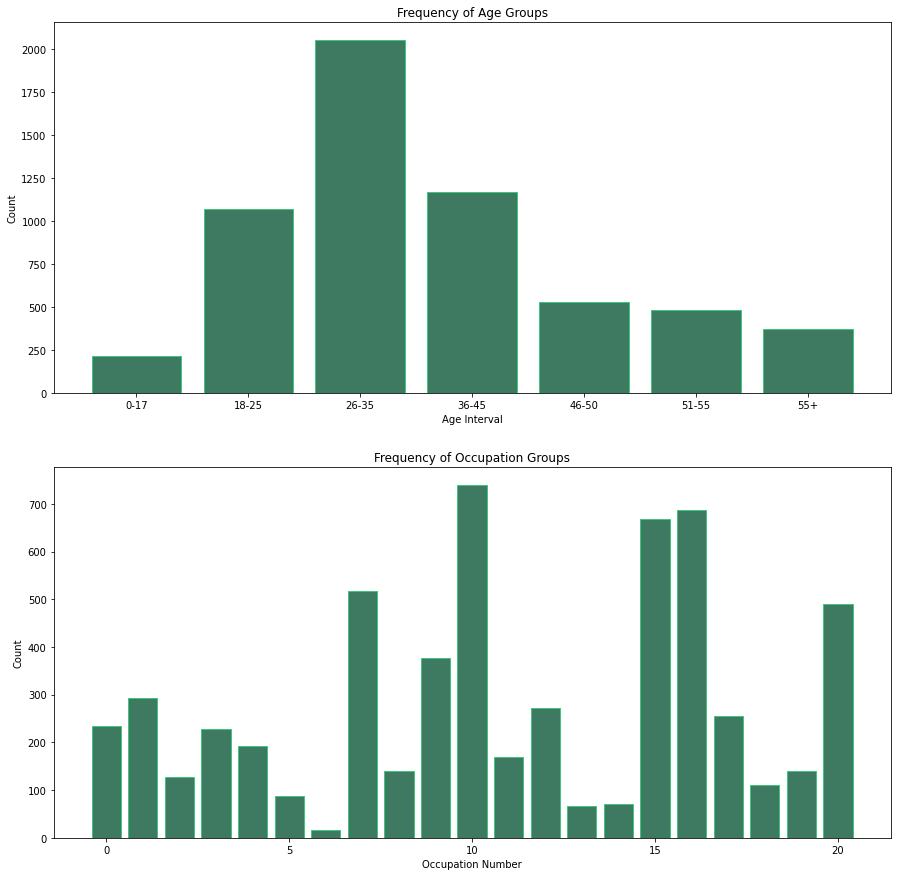

In [12]:

fig = plt.figure(figsize = (15, 15))

colors1 = ['#267A4C','#99FBC5','#4DFA9B','#3E7A61','#3EC77C']

plt.subplot(2, 1, 1)
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
plt.bar(ageInterval, dfAgeCounts, color=(colors1[3]),  edgecolor=(colors1[4]))
plt.xlabel("Age Interval")
plt.ylabel("Count")
plt.title("Frequency of Age Groups")


plt.subplot(2, 1, 2)
# ax = fig.add_axes([0,0,1,1])
plt.bar(droppDuppiesDf.Occupation.unique(), droppDuppiesDf.Occupation.value_counts(), color=(colors1[3]),  edgecolor=(colors1[4]))
plt.xlabel("Occupation Number")
plt.ylabel("Count")
plt.title("Frequency of Occupation Groups")


plt.show()


In [13]:
yearInCityVal = [772,2086,1145,979,909]
yearsInCityLabel = ['0','1','2','3','4+']

In [14]:
droppDuppiesDf.Gender.unique()
droppDuppiesDf.Gender.value_counts()

M    4225
F    1666
Name: Gender, dtype: int64

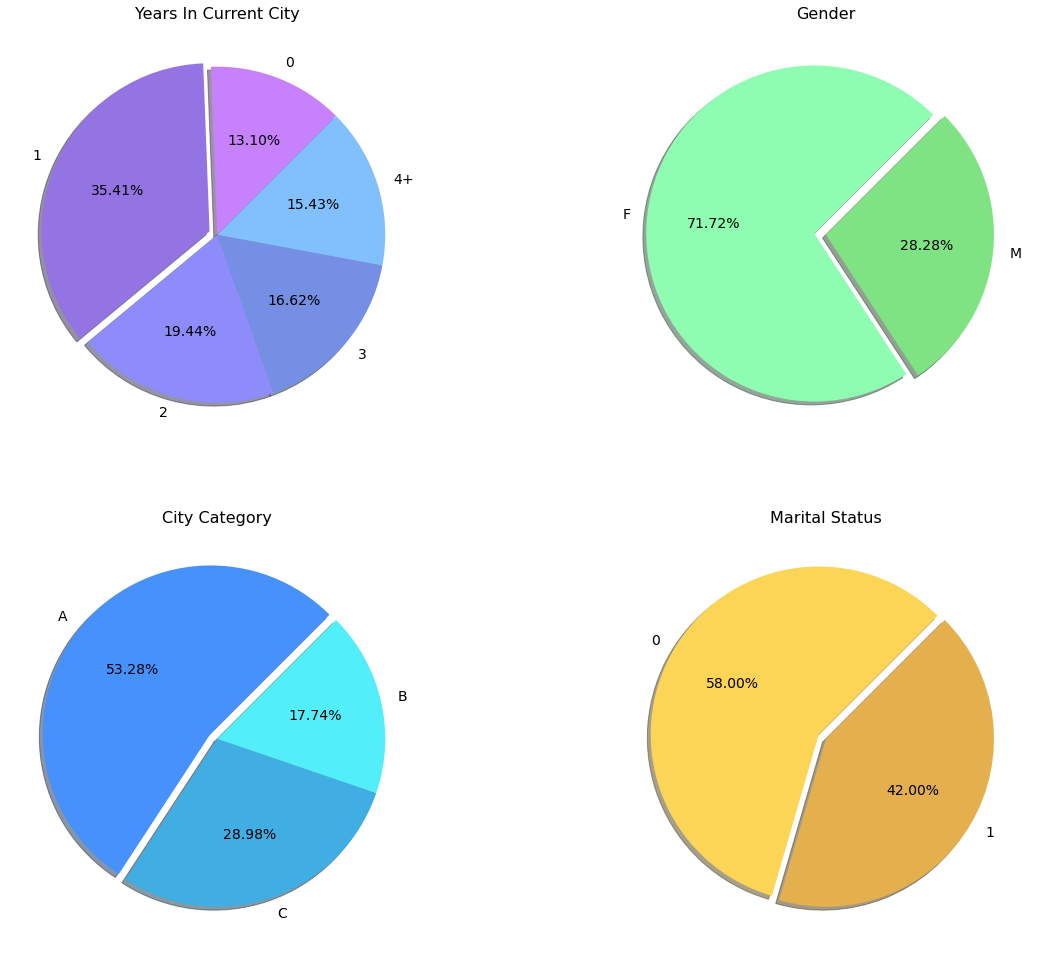

In [15]:
colorrr = ["#C781FD", "#9474E3","#8E8CFA", "#748FE3",'#81C0FD']
colorrr2 = ["#4791FD", "#40ADE3","#52EFFA", "#40E3C0",'#47FDA3']
colorrr3 = ["#8EFDB1", "#7FE383","#B5FA98", "#C0E37F",'#FCFD8E']
colorrr4 = ["#FDD556", "#E3B04D","#FAB461", "#E38A4D",'#FD8156']
fig = plt.figure(figsize = (20, 17))
plt.subplot(2, 2, 1)
plt.pie(yearInCityVal,
        labels = yearsInCityLabel,
        startangle = 45,
        autopct = '%1.2f%%',
        colors = colorrr,
        shadow = True,
        explode = [0,.05,0,0,0],
        textprops={'color':"black",'fontsize': 14}
        )
plt.title('Years In Current City',color='black',fontsize= 16)
plt.plot()


plt.subplot(2, 2, 2)


plt.pie(droppDuppiesDf.Gender.value_counts(),
        labels = droppDuppiesDf.Gender.unique(),
        textprops={'color':"black",'fontsize': 14},
        startangle = 45,
        autopct = '%1.2f%%',
        colors = colorrr3,
        shadow = True,
        explode = [0.07,.0]
        )
plt.plot()
plt.title('Gender',color='black',fontsize= 16)


plt.subplot(2, 2, 3)
plt.pie(droppDuppiesDf.City_Category.value_counts(),
        labels = droppDuppiesDf.City_Category.unique(),
        startangle = 45,
        autopct = '%1.2f%%',
        colors = colorrr2,
        shadow = True,
        explode = [0.05,.0,0],
        textprops={'color':"black",'fontsize': 14}
        )
plt.title('City Category',color='black',fontsize= 16)
plt.plot()


plt.subplot(2, 2, 4)


plt.pie(droppDuppiesDf.Marital_Status.value_counts(),
        labels = droppDuppiesDf.Marital_Status.unique(),
        textprops={'color':"black",'fontsize': 14},
        startangle = 45,
        autopct = '%1.2f%%',
        colors = colorrr4,
        shadow = True,
        explode = [0.05,.0,]
        )
plt.plot()
plt.title('Marital Status',color='black',fontsize= 16)

plt.show()

GroupDf takes the mean value of each numerical values with repect to UserID

In [16]:
groupDf = df.groupby(['User_ID']).mean()
tempx = np.arange(len(groupDf))
groupDf

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,,,,,,
1000001,10.0,0.0,6.085714,6.285714,10.571429,9545.514286
1000002,16.0,0.0,4.597403,9.981481,13.807692,10525.610390
1000003,15.0,0.0,3.206897,5.086957,11.384615,11780.517241
1000004,7.0,1.0,2.357143,8.500000,14.111111,14747.714286
1000005,20.0,1.0,6.216981,11.068966,12.937500,7745.292453
...,...,...,...,...,...,...
1006036,15.0,1.0,6.225681,10.667712,13.718182,8007.894942
1006037,1.0,0.0,7.688525,12.081081,13.818182,9176.540984
1006038,1.0,0.0,6.916667,10.333333,17.000000,7502.833333


OKAY so here I add a new columsn  - disc  interval-- with 20 bins. I played around with it a bit. I settled on 20, feel free to try other bin sizes too.

In [17]:
 groupDf["discrete_intervals"] = pd.cut(groupDf["Purchase"], bins=20, include_lowest=True)

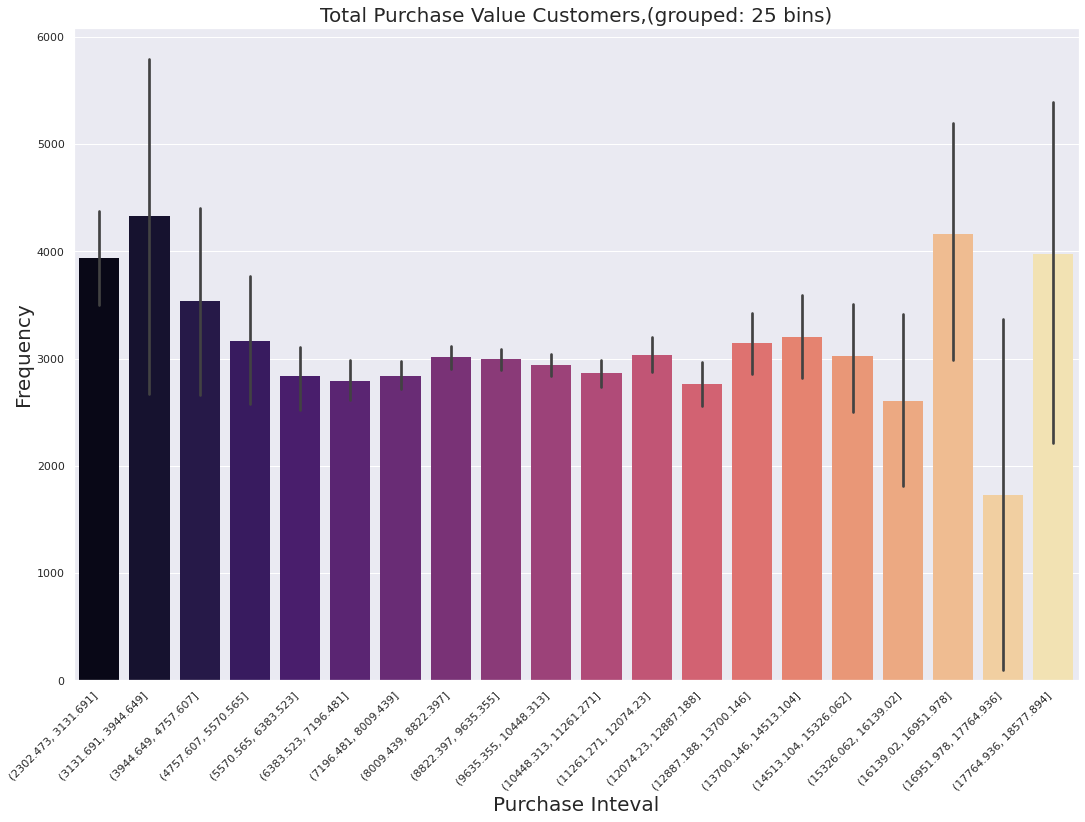

In [18]:
tempx2 = np.arange(len(groupDf))

sns.set(rc = {'figure.figsize':(18,12)})
ax = sns.barplot(x="discrete_intervals", y=tempx2, palette='magma', data=groupDf, edgecolor="none")
ax.set_xlabel('Purchase Inteval',fontsize=20)
ax.set_ylabel('Frequency',fontsize=20)
# plt.xticks([])
plt.xticks(rotation = 45, ha='right') 
plt.title("Total Purchase Value Customers,(grouped: 25 bins)", fontsize=20)
plt.show()

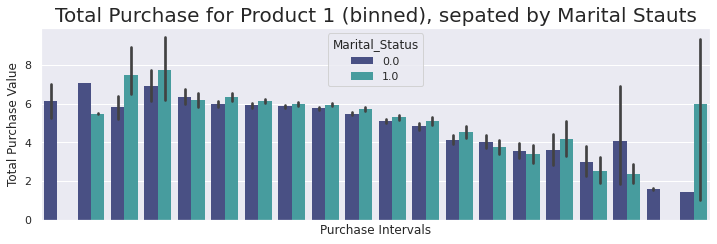

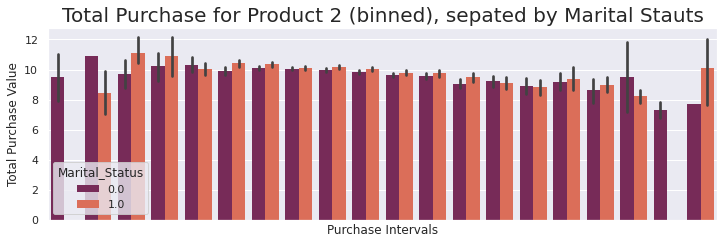

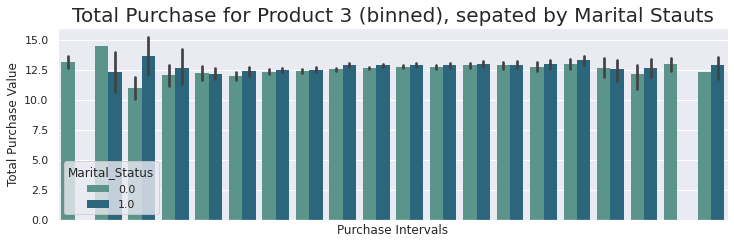

In [19]:
sns.set(rc = {'figure.figsize':(12,12)})

fsize = 12

plt.subplot(3, 1, 1)
ax = sns.barplot(x='discrete_intervals', y='Product_Category_1', hue='Marital_Status', data=groupDf, palette = ('mako'), edgecolor="none")
ax.set_xlabel('Purchase Intervals',fontsize=fsize)
ax.set_ylabel('Total Purchase Value',fontsize=fsize)
plt.title("Total Purchase for Product 1 (binned), sepated by Marital Stauts", fontsize=20)
# plt.xticks(rotation = 45, ha='right') 
plt.xticks([])
plt.show()


plt.subplot(3, 1, 2)
ax = sns.barplot(x='discrete_intervals', y='Product_Category_2', hue='Marital_Status', data=groupDf, palette = ('rocket'), edgecolor="none")
ax.set_xlabel('Purchase Intervals',fontsize=fsize)
ax.set_ylabel('Total Purchase Value',fontsize=fsize)
plt.title("Total Purchase for Product 2 (binned), sepated by Marital Stauts", fontsize=20)
# plt.xticks(rotation = 45, ha='right') 
plt.xticks([])
plt.show()

plt.subplot(3, 1, 3)
ax = sns.barplot(x='discrete_intervals', y='Product_Category_3', hue='Marital_Status', data=groupDf, palette = ('crest'), edgecolor="none")
ax.set_xlabel('Purchase Intervals',fontsize=fsize)
ax.set_ylabel('Total Purchase Value',fontsize=fsize)
plt.title("Total Purchase for Product 3 (binned), sepated by Marital Stauts", fontsize=20)
# plt.xticks(rotation = 45, ha='right') 
plt.xticks([])
plt.show()

So, I have concer for this above plot, I know its off, Basically since its split by the discreete interval, its counting purchases from cat_1 as also cat_3. Anyways, I will adjust it or remove it later... Hah I also know relize I didnt even need to create the below df. I thought I would use the purchase Info, may later still.


In [20]:
dfSplitPurchase = df

In [21]:
 dfSplitPurchase["discrete_intervals"] = pd.cut(df["Purchase"], 
 							 bins=25,
                             include_lowest=True)

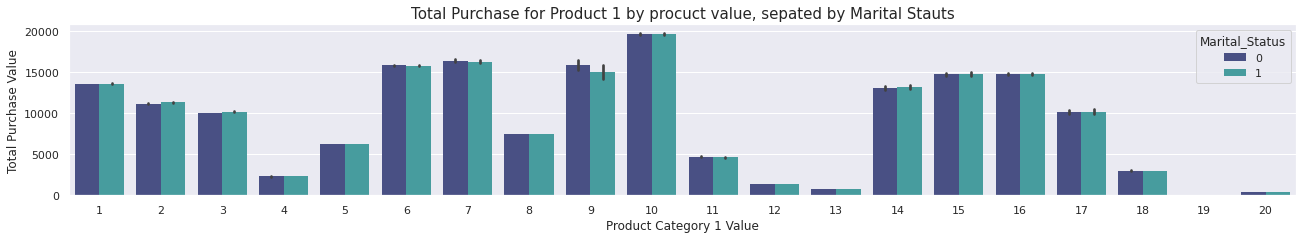

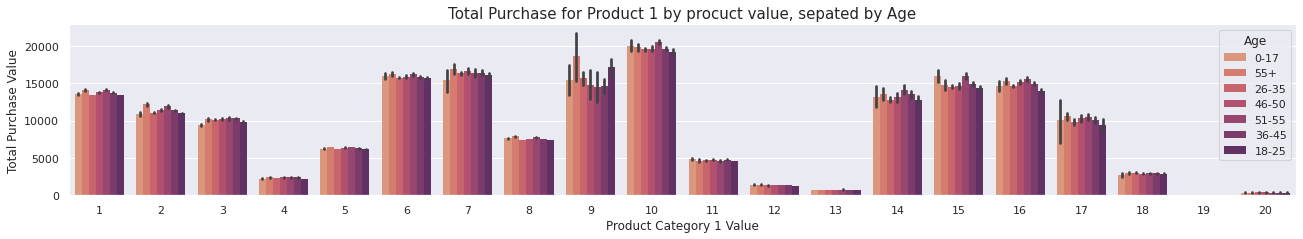

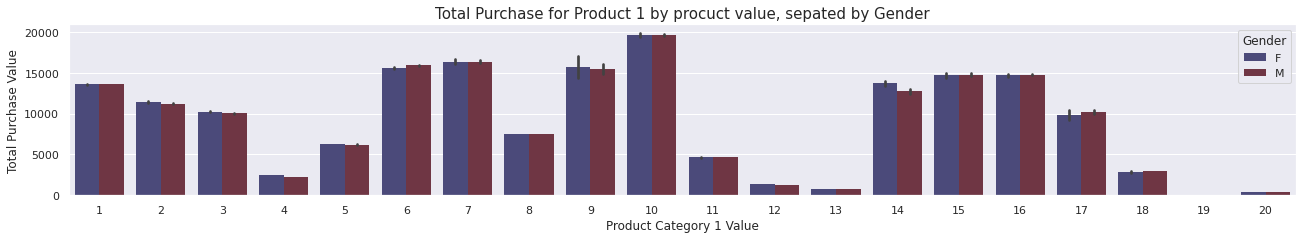

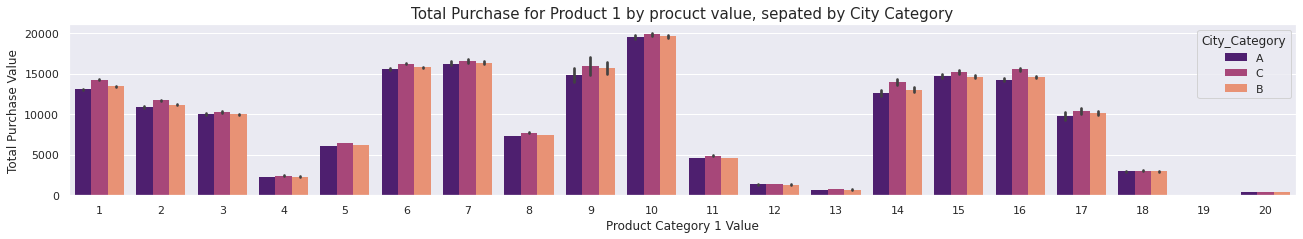

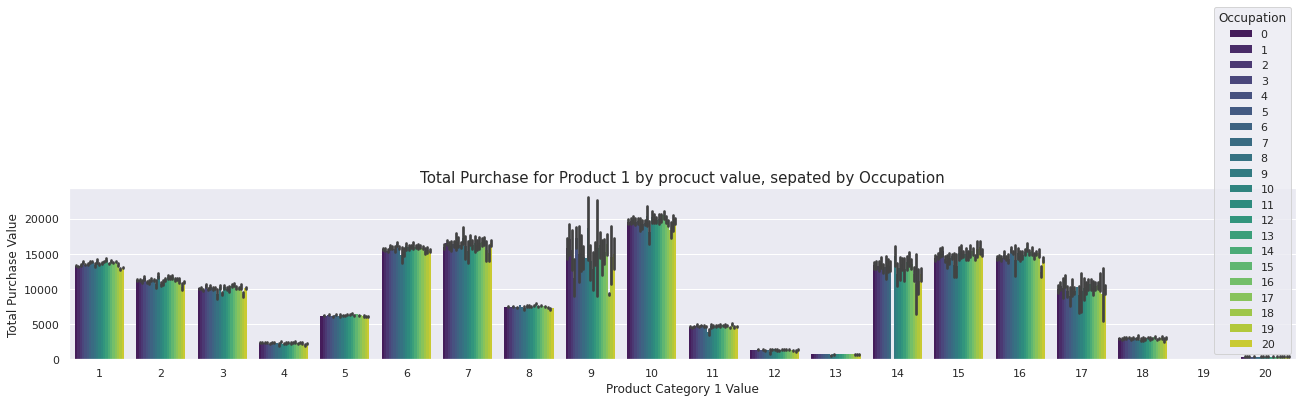

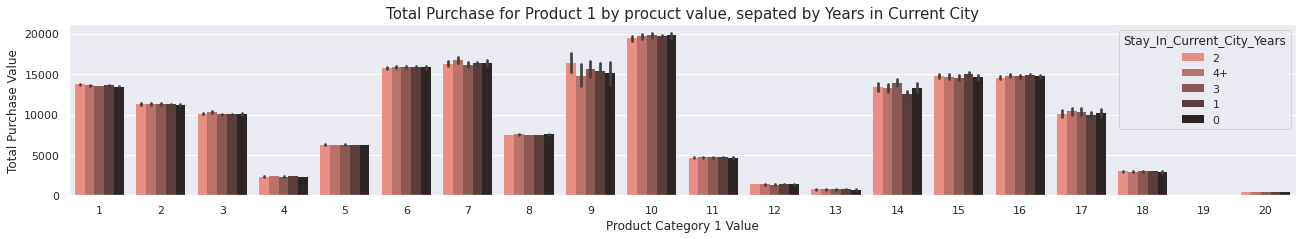

In [22]:
sns.set(rc = {'figure.figsize':(22,22)})

fsize = 12
tsize = 15

plt.subplot(6, 1, 1)
ax = sns.barplot(x='Product_Category_1', y='Purchase', hue='Marital_Status', data=dfSplitPurchase, palette = ('mako'), edgecolor="none")
ax.set_xlabel('Product Category 1 Value',fontsize=fsize)
ax.set_ylabel('Total Purchase Value',fontsize=fsize)
plt.title("Total Purchase for Product 1 by procuct value, sepated by Marital Stauts", fontsize=tsize)
# plt.xticks(rotation = 45, ha='right') 
# plt.xticks([])
plt.show()

plt.subplot(6, 1, 2)
ax = sns.barplot(x='Product_Category_1', y='Purchase', hue='Age', data=dfSplitPurchase, palette = ('flare'), edgecolor="none")
ax.set_xlabel('Product Category 1 Value',fontsize=fsize)
ax.set_ylabel('Total Purchase Value',fontsize=fsize)
plt.title("Total Purchase for Product 1 by procuct value, sepated by Age", fontsize=tsize)
# plt.xticks(rotation = 45, ha='right') 
# plt.xticks([])
plt.show()

plt.subplot(6, 1, 3)
ax = sns.barplot(x='Product_Category_1', y='Purchase', hue='Gender', data=dfSplitPurchase, palette = ('icefire'), edgecolor="none")
ax.set_xlabel('Product Category 1 Value',fontsize=fsize)
ax.set_ylabel('Total Purchase Value',fontsize=fsize)
plt.title("Total Purchase for Product 1 by procuct value, sepated by Gender", fontsize=tsize)
# plt.xticks(rotation = 45, ha='right') 
# plt.xticks([])
plt.show()

plt.subplot(6, 1, 3)
ax = sns.barplot(x='Product_Category_1', y='Purchase', hue='City_Category', data=dfSplitPurchase, palette = ('magma'), edgecolor="none")
ax.set_xlabel('Product Category 1 Value',fontsize=fsize)
ax.set_ylabel('Total Purchase Value',fontsize=fsize)
plt.title("Total Purchase for Product 1 by procuct value, sepated by City Category", fontsize=tsize)
# plt.xticks(rotation = 45, ha='right') 
# plt.xticks([])
plt.show()

plt.subplot(6, 1, 3)
ax = sns.barplot(x='Product_Category_1', y='Purchase', hue='Occupation', data=dfSplitPurchase, palette = ('viridis'), edgecolor="none")
ax.set_xlabel('Product Category 1 Value',fontsize=fsize)
ax.set_ylabel('Total Purchase Value',fontsize=fsize)
plt.title("Total Purchase for Product 1 by procuct value, sepated by Occupation", fontsize=tsize)
# plt.xticks(rotation = 45, ha='right') 
# plt.xticks([])
plt.show()

plt.subplot(6, 1, 3)
ax = sns.barplot(x='Product_Category_1', y='Purchase', hue='Stay_In_Current_City_Years', data=dfSplitPurchase, palette = ('dark:salmon_r'), edgecolor="none")
ax.set_xlabel('Product Category 1 Value',fontsize=fsize)
ax.set_ylabel('Total Purchase Value',fontsize=fsize)
plt.title("Total Purchase for Product 1 by procuct value, sepated by Years in Current City", fontsize=tsize)
# plt.xticks(rotation = 45, ha='right') 
# plt.xticks([])
plt.show()



## **Encoding Data and Cleasning**

My computer doesnt have enough ram to run the ANN model so i just added this here temparaily since I had to keep restarting

In [23]:
# My computer doesnt have enough ram to run the ANN model so i just added this here temparaily since I had to keep restarting
df=pd.read_csv("blackfriday_train.csv")

In [24]:
df.Age.replace({'0-17':0,'18-25':1,'26-35':2,'36-45':3,'46-50':4,'51-55':5,'55+':6},inplace=True)

In [25]:
df.Product_Category_2.fillna(0,inplace=True)
df.Product_Category_3.fillna(0,inplace=True)


In [26]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,F,0,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,F,0,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,M,6,16,C,4+,0,8,0.0,0.0,7969


In [27]:
df.Stay_In_Current_City_Years.replace({'4+':4},inplace=True)

In [28]:
df.Gender.replace({'F':0,'M':1},inplace=True) 

In [29]:
df.City_Category.replace({'A':0,'B':1,'C':2},inplace=True)

In [30]:
df.Stay_In_Current_City_Years.unique()

array(['2', 4, '3', '1', '0'], dtype=object)

In [31]:
df.Stay_In_Current_City_Years=df.Stay_In_Current_City_Years.astype(str).astype(int)

In [32]:
df["Product_ID"]=df["Product_ID"].str[1:]

In [33]:
df["Product_ID"]=df["Product_ID"].astype(str).astype(int)

In [34]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,69042,0,0,10,0,2,0,3,0.0,0.0,8370
1,1000001,248942,0,0,10,0,2,0,1,6.0,14.0,15200
2,1000001,87842,0,0,10,0,2,0,12,0.0,0.0,1422
3,1000001,85442,0,0,10,0,2,0,12,14.0,0.0,1057
4,1000002,285442,1,6,16,2,4,0,8,0.0,0.0,7969


In [35]:
df.corr()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.017619,-0.033474,0.032698,-0.023971,0.022859,-0.030737,0.020443,0.003825,0.003896,0.003605,0.004716
Product_ID,-0.017619,1.000000,0.021084,0.028892,0.009344,0.010162,-0.003162,0.013194,0.090193,-0.090600,-0.144360,-0.103961
Gender,-0.033474,0.021084,1.000000,-0.004262,0.117291,-0.004515,0.014660,-0.011603,-0.045594,-0.000954,0.036146,0.060346
Age,0.032698,0.028892,-0.004262,1.000000,0.091463,0.123079,-0.004712,0.311738,0.061197,0.018770,-0.007422,0.015839
Occupation,-0.023971,0.009344,0.117291,0.091463,1.000000,0.034479,0.030005,0.024280,-0.007618,0.006712,0.012269,0.020833
City_Category,0.022859,0.010162,-0.004515,0.123079,0.034479,1.000000,0.019946,0.039790,-0.014364,0.016003,0.035525,0.061914
Stay_In_Current_City_Years,-0.030737,-0.003162,0.014660,-0.004712,0.030005,0.019946,1.000000,-0.012819,-0.004213,0.001262,0.001977,0.005422
Marital_Status,0.020443,0.013194,-0.011603,0.311738,0.024280,0.039790,-0.012819,1.000000,0.019888,0.001099,-0.004629,-0.000463
Product_Category_1,0.003825,0.090193,-0.045594,0.061197,-0.007618,-0.014364,-0.004213,0.019888,1.000000,-0.067877,-0.385534,-0.343703
Product_Category_2,0.003896,-0.090600,-0.000954,0.018770,0.006712,0.016003,0.001262,0.001099,-0.067877,1.000000,0.094750,0.052288


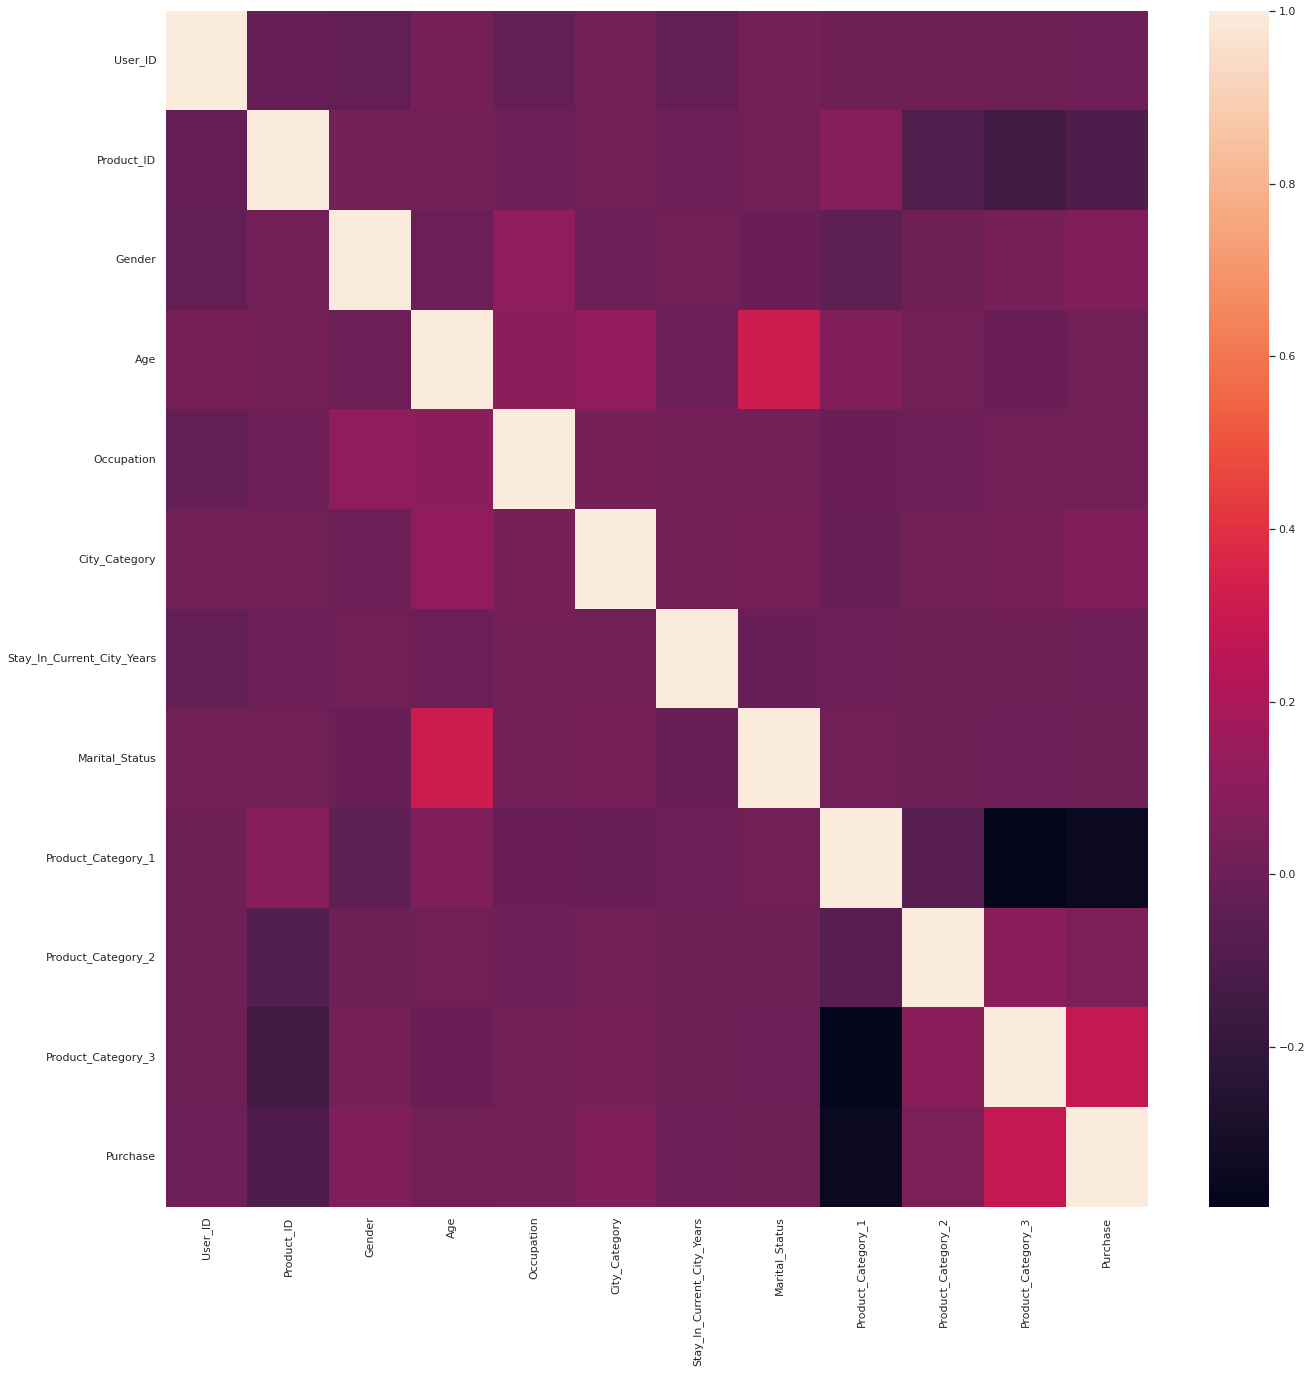

In [36]:
sns.heatmap(df.corr())

(array([60327., 48459., 66463., 76687., 54864., 57198., 52979., 52154.,
        44289., 36648.]),
 array([1.420000e+02, 3.767140e+04, 7.520080e+04, 1.127302e+05,
        1.502596e+05, 1.877890e+05, 2.253184e+05, 2.628478e+05,
        3.003772e+05, 3.379066e+05, 3.754360e+05]),
 <a list of 10 Patch objects>)

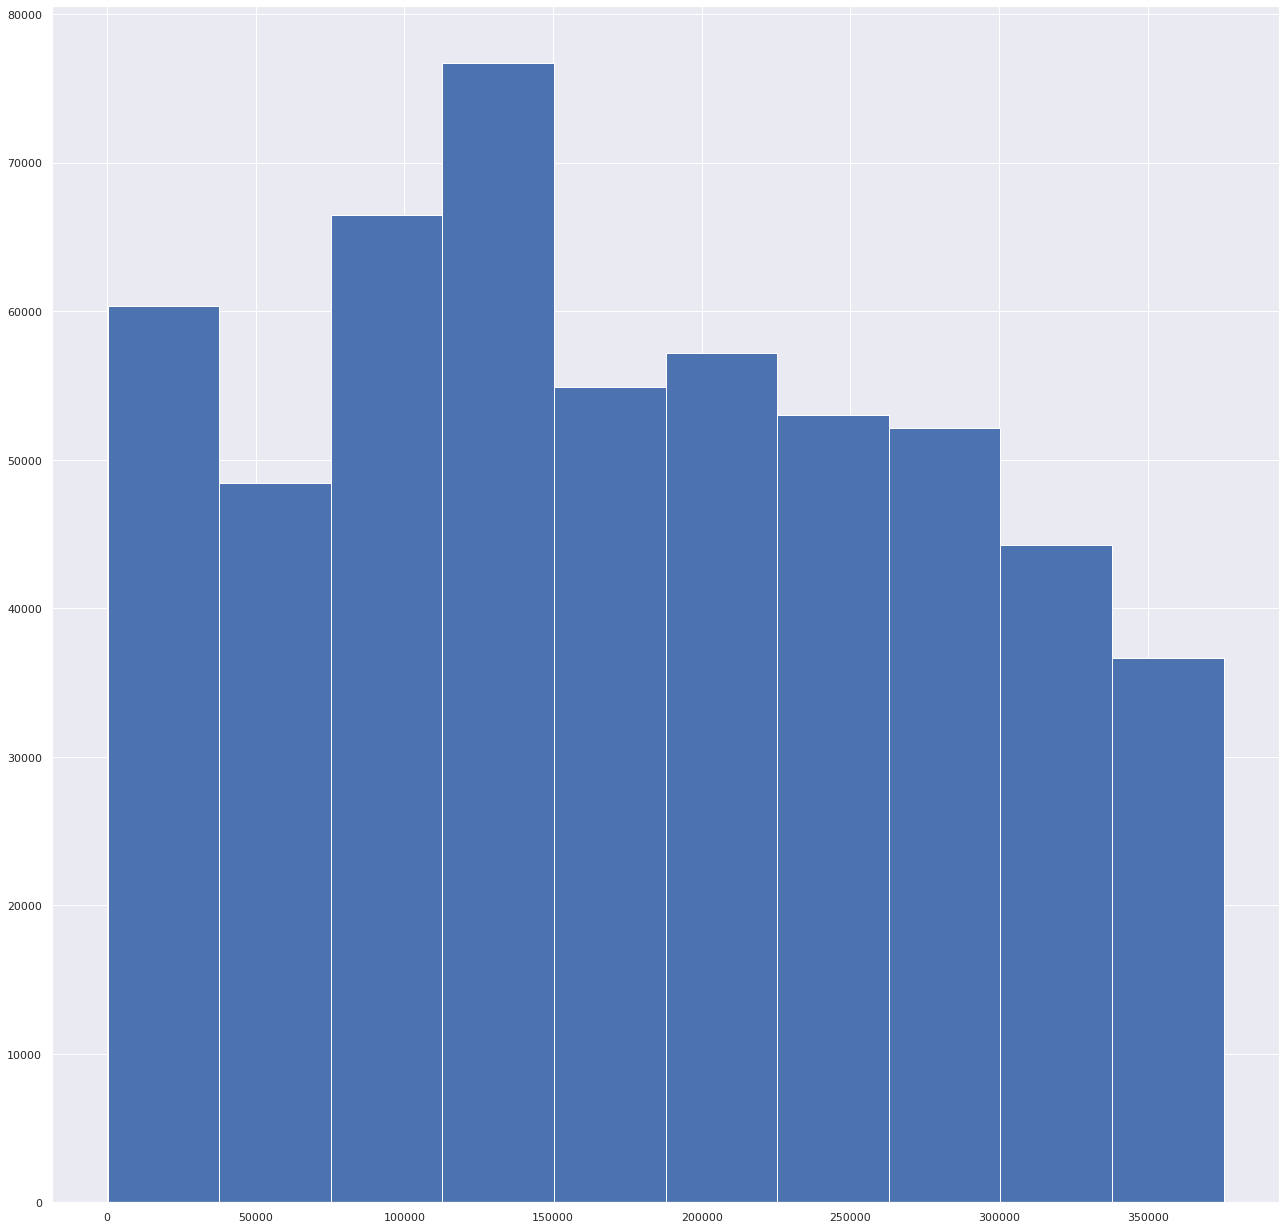

In [37]:
plt.hist(df.Product_ID) #histogram

{'whiskers': [<matplotlib.lines.Line2D at 0x7f117326d450>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1173288a10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f11732886d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f117328e490>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f117328e9d0>],
 'means': []}

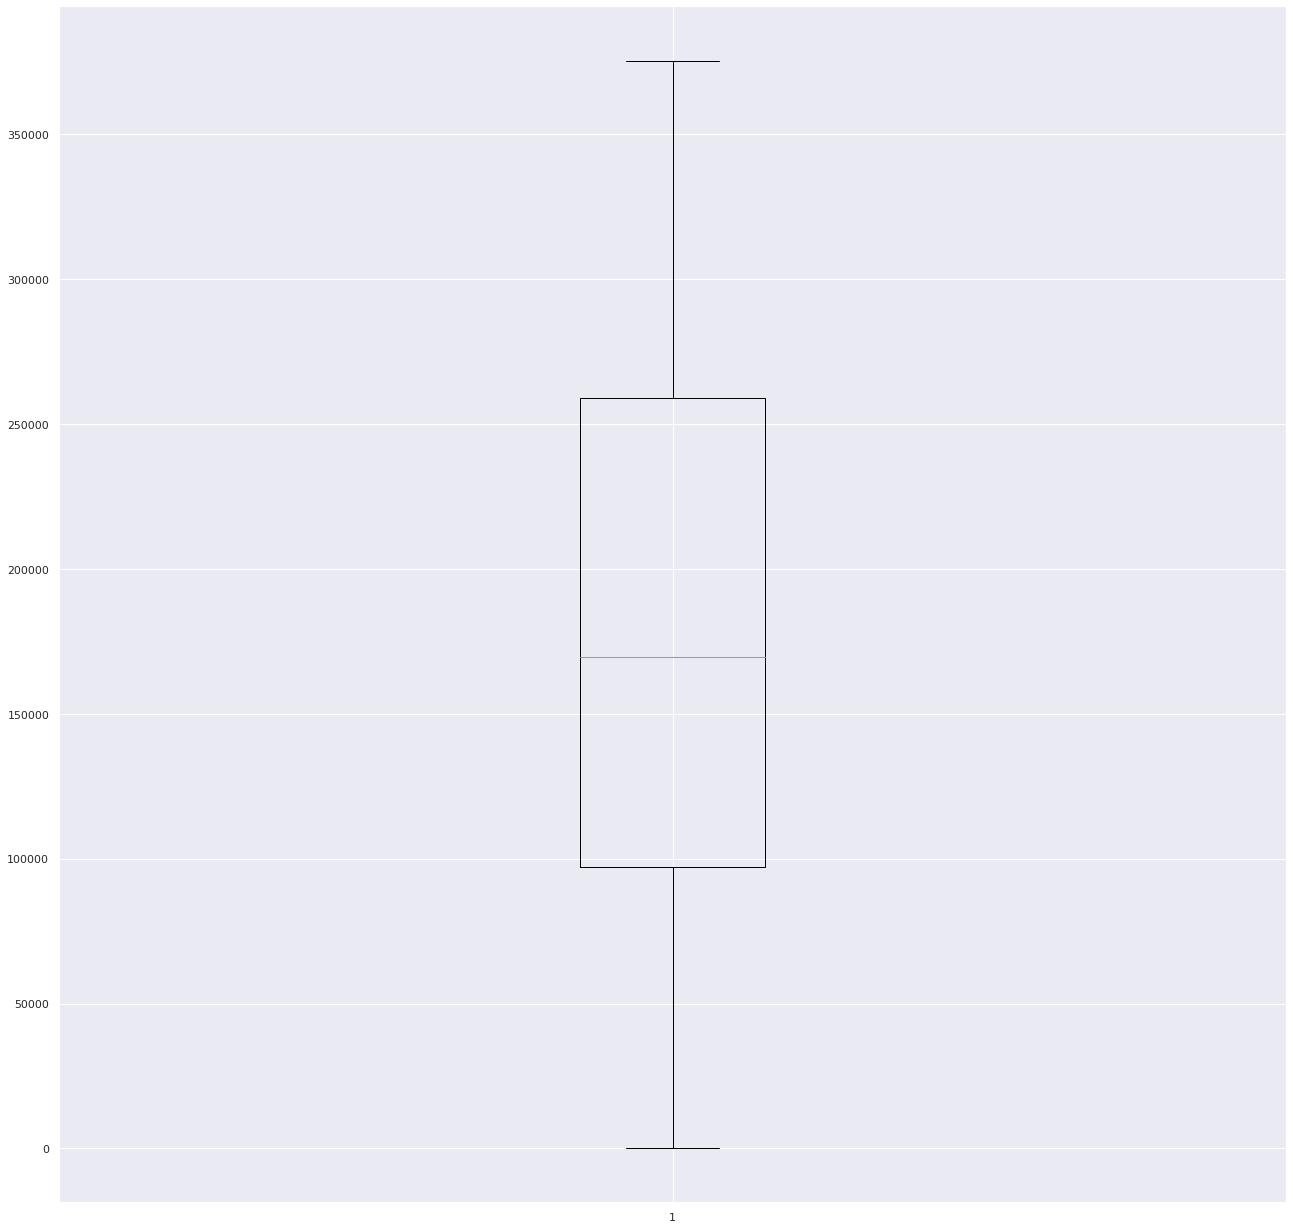

In [38]:
plt.boxplot(df.Product_ID)

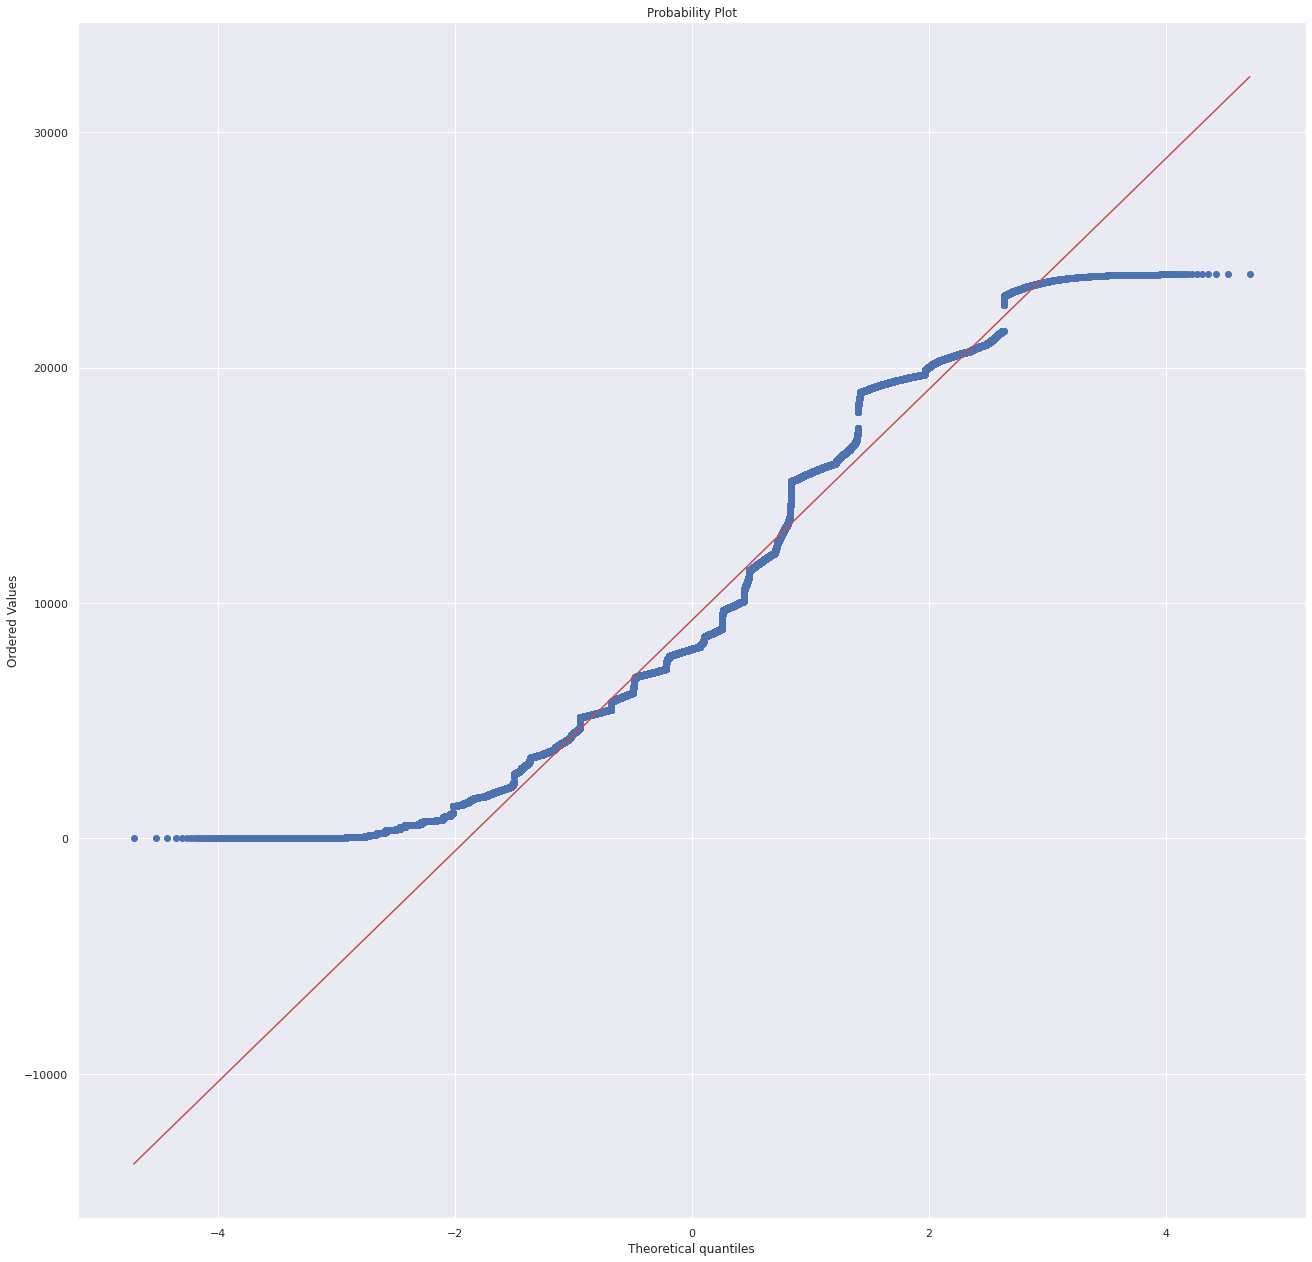

In [39]:
stats.probplot(df.Purchase, dist = "norm", plot = pylab)
plt.show()

In [40]:
#sns.pairplot(df.iloc[:, :])

In [41]:
mlr_model_df=df.drop(columns=['User_ID','Product_ID'])
mlr_model_df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,0,10,0,2,0,3,0.0,0.0,8370
1,0,0,10,0,2,0,1,6.0,14.0,15200
2,0,0,10,0,2,0,12,0.0,0.0,1422
3,0,0,10,0,2,0,12,14.0,0.0,1057
4,1,6,16,2,4,0,8,0.0,0.0,7969


In [42]:
nm=MinMaxScaler()

In [43]:
mlr_columns=mlr_model_df.columns
mlr_columns

Index(['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [44]:
mlr_model_df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,0,10,0,2,0,3,0.0,0.0,8370
1,0,0,10,0,2,0,1,6.0,14.0,15200
2,0,0,10,0,2,0,12,0.0,0.0,1422
3,0,0,10,0,2,0,12,14.0,0.0,1057
4,1,6,16,2,4,0,8,0.0,0.0,7969


created a non normalized df of our mlr model to possibly group by ages

In [45]:
mlr_model_df_nn=mlr_model_df

In [46]:
mlr_model_df=pd.DataFrame(nm.fit_transform(mlr_model_df))
mlr_model_df.columns=['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase']
mlr_model_df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0.0,0.000000,0.50,0.0,0.50,0.0,0.105263,0.000000,0.000000,0.348992
1,0.0,0.000000,0.50,0.0,0.50,0.0,0.000000,0.333333,0.777778,0.634181
2,0.0,0.000000,0.50,0.0,0.50,0.0,0.578947,0.000000,0.000000,0.058875
3,0.0,0.000000,0.50,0.0,0.50,0.0,0.578947,0.777778,0.000000,0.043634
4,1.0,1.000000,0.80,1.0,1.00,0.0,0.368421,0.000000,0.000000,0.332248
...,...,...,...,...,...,...,...,...,...,...
550063,1.0,0.833333,0.65,0.5,0.25,1.0,1.000000,0.000000,0.000000,0.014865
550064,0.0,0.333333,0.05,1.0,0.75,0.0,1.000000,0.000000,0.000000,0.014990
550065,0.0,0.333333,0.75,0.5,1.00,1.0,1.000000,0.000000,0.000000,0.005219
550066,0.0,1.000000,0.05,1.0,0.50,0.0,1.000000,0.000000,0.000000,0.014740


In [47]:
ml1 = smf.ols('Purchase ~ Gender + Age + Occupation + City_Category + Stay_In_Current_City_Years + Marital_Status + Product_Category_1 + Product_Category_2 + Product_Category_3', data = mlr_model_df).fit() # regression model
ml1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Purchase   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                 1.097e+04
Date:                Fri, 19 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:58:15   Log-Likelihood:             1.2404e+05
No. Observations:              550068   AIC:                        -2.481e+05
Df Residuals:                  550058   BIC:                        -2.480e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3822      0.001    379.835      0.000       0.380       0.384
Gender                         0.0199      0.001     32.622      0.000       0.019       0.021
Age                            0.0266      0.001     21.650      0.000       0.024       0.029
Occupation                     0.0048      0.001      5.924      0.000       0.003       0.006
City_Category                  0.0265      0.001     38.276      0.000       0.025       0.028
Stay_In_Current_City_Years     0.0014      0.001      1.767      0.077      -0.000       0.003
Marital_Status                -0.0020      0.001     -3.631      0.000      -0.003      -0.001
Product_Category_1            -0.2761      0.001   -202.060      0.000      -0.279      -0.273
Product_Category_2             0.0094      0.001     12.433      0.000       0.008       0.011
Product_Category_3             0.1080      0.001    132.401      0.000       0.106       0.110
==============================================================================
Omnibus:                    57263.559   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79655.860
Skew:                           0.833   Prob(JB):                         0.00
Kurtosis:                       3.836   Cond. No.                         9.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-Value for Stay_In_Current_City_Years is more than 0.05

In [48]:
# Check for Colinearity to decide to remove a variable using VIF
# Assumption: VIF > 10 = colinearity
# calculating VIF's values of independent variables
rsq_gender = smf.ols('Gender ~  Age + Occupation + City_Category + Stay_In_Current_City_Years + Marital_Status + Product_Category_1 + Product_Category_2 + Product_Category_3', data = mlr_model_df).fit().rsquared  
vif_gender = 1/(1 - rsq_gender) 

rsq_age = smf.ols('Age ~  Gender + Occupation + City_Category + Stay_In_Current_City_Years + Marital_Status + Product_Category_1 + Product_Category_2 + Product_Category_3', data = mlr_model_df).fit().rsquared  
vif_age = 1/(1 - rsq_age)

rsq_occupation = smf.ols('Occupation ~  Age + Gender + City_Category + Stay_In_Current_City_Years + Marital_Status + Product_Category_1 + Product_Category_2 + Product_Category_3', data = mlr_model_df).fit().rsquared  
vif_occupation = 1/(1 - rsq_occupation) 

rsq_cc = smf.ols('City_Category ~  Age + Occupation + Gender + Stay_In_Current_City_Years + Marital_Status + Product_Category_1 + Product_Category_2 + Product_Category_3', data = mlr_model_df).fit().rsquared  
vif_cc = 1/(1 - rsq_cc) 

rsq_siccy = smf.ols('Stay_In_Current_City_Years ~  Gender + Age + Occupation + City_Category + Marital_Status + Product_Category_1 + Product_Category_2 + Product_Category_3', data = mlr_model_df).fit().rsquared  
vif_siccy = 1/(1 - rsq_siccy)

rsq_ms = smf.ols('Marital_Status ~  Age + Gender + Occupation + City_Category + Stay_In_Current_City_Years + Product_Category_1 + Product_Category_2 + Product_Category_3', data = mlr_model_df).fit().rsquared  
vif_ms = 1/(1 - rsq_ms)

rsq_pc1 = smf.ols('Product_Category_1 ~  Age + Occupation + Gender + City_Category + Stay_In_Current_City_Years + Marital_Status + Product_Category_2 + Product_Category_3', data = mlr_model_df).fit().rsquared  
vif_pc1 = 1/(1 - rsq_pc1) 

rsq_pc2 = smf.ols('Product_Category_2 ~  Gender + Age + Occupation + City_Category + Stay_In_Current_City_Years + Marital_Status + Product_Category_1 + Product_Category_3', data = mlr_model_df).fit().rsquared  
vif_pc2 = 1/(1 - rsq_pc2)

rsq_pc3 = smf.ols('Product_Category_3 ~  Age + Gender + Occupation + City_Category + Stay_In_Current_City_Years + Marital_Status + Product_Category_1 + Product_Category_2', data = mlr_model_df).fit().rsquared  
vif_pc3 = 1/(1 - rsq_pc3)

print('vif_gender',vif_gender,'vif_age',vif_age,'vif_occupation',vif_occupation)
print('vif_cc',vif_cc,'vif_siccy',vif_siccy,'vif_ms',vif_ms)
print('vif_pc1',vif_pc1,'vif_pc2',vif_pc2,'vif_pc3',vif_pc3)

vif_gender 1.0168815042735742 vif_age 1.1360670886551578 vif_occupation 1.0242614730441164
vif_cc 1.017947433968261 vif_siccy 1.0016293962798941 vif_ms 1.107968827999873
vif_pc1 1.1822948608980552 vif_pc2 1.0108877037649215 vif_pc3 1.1830277018939737


In [49]:
final_mlr_model = smf.ols('Purchase ~ Gender + Age + Occupation + City_Category + Stay_In_Current_City_Years + Marital_Status + Product_Category_1 + Product_Category_2 + Product_Category_3', data = mlr_model_df).fit()
final_mlr_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Purchase   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                 1.097e+04
Date:                Fri, 19 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:58:21   Log-Likelihood:             1.2404e+05
No. Observations:              550068   AIC:                        -2.481e+05
Df Residuals:                  550058   BIC:                        -2.480e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3822      0.001    379.835      0.000       0.380       0.384
Gender                         0.0199      0.001     32.622      0.000       0.019       0.021
Age                            0.0266      0.001     21.650      0.000       0.024       0.029
Occupation                     0.0048      0.001      5.924      0.000       0.003       0.006
City_Category                  0.0265      0.001     38.276      0.000       0.025       0.028
Stay_In_Current_City_Years     0.0014      0.001      1.767      0.077      -0.000       0.003
Marital_Status                -0.0020      0.001     -3.631      0.000      -0.003      -0.001
Product_Category_1            -0.2761      0.001   -202.060      0.000      -0.279      -0.273
Product_Category_2             0.0094      0.001     12.433      0.000       0.008       0.011
Product_Category_3             0.1080      0.001    132.401      0.000       0.106       0.110
==============================================================================
Omnibus:                    57263.559   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79655.860
Skew:                           0.833   Prob(JB):                         0.00
Kurtosis:                       3.836   Cond. No.                         9.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
pred = final_mlr_model.predict(mlr_model_df)

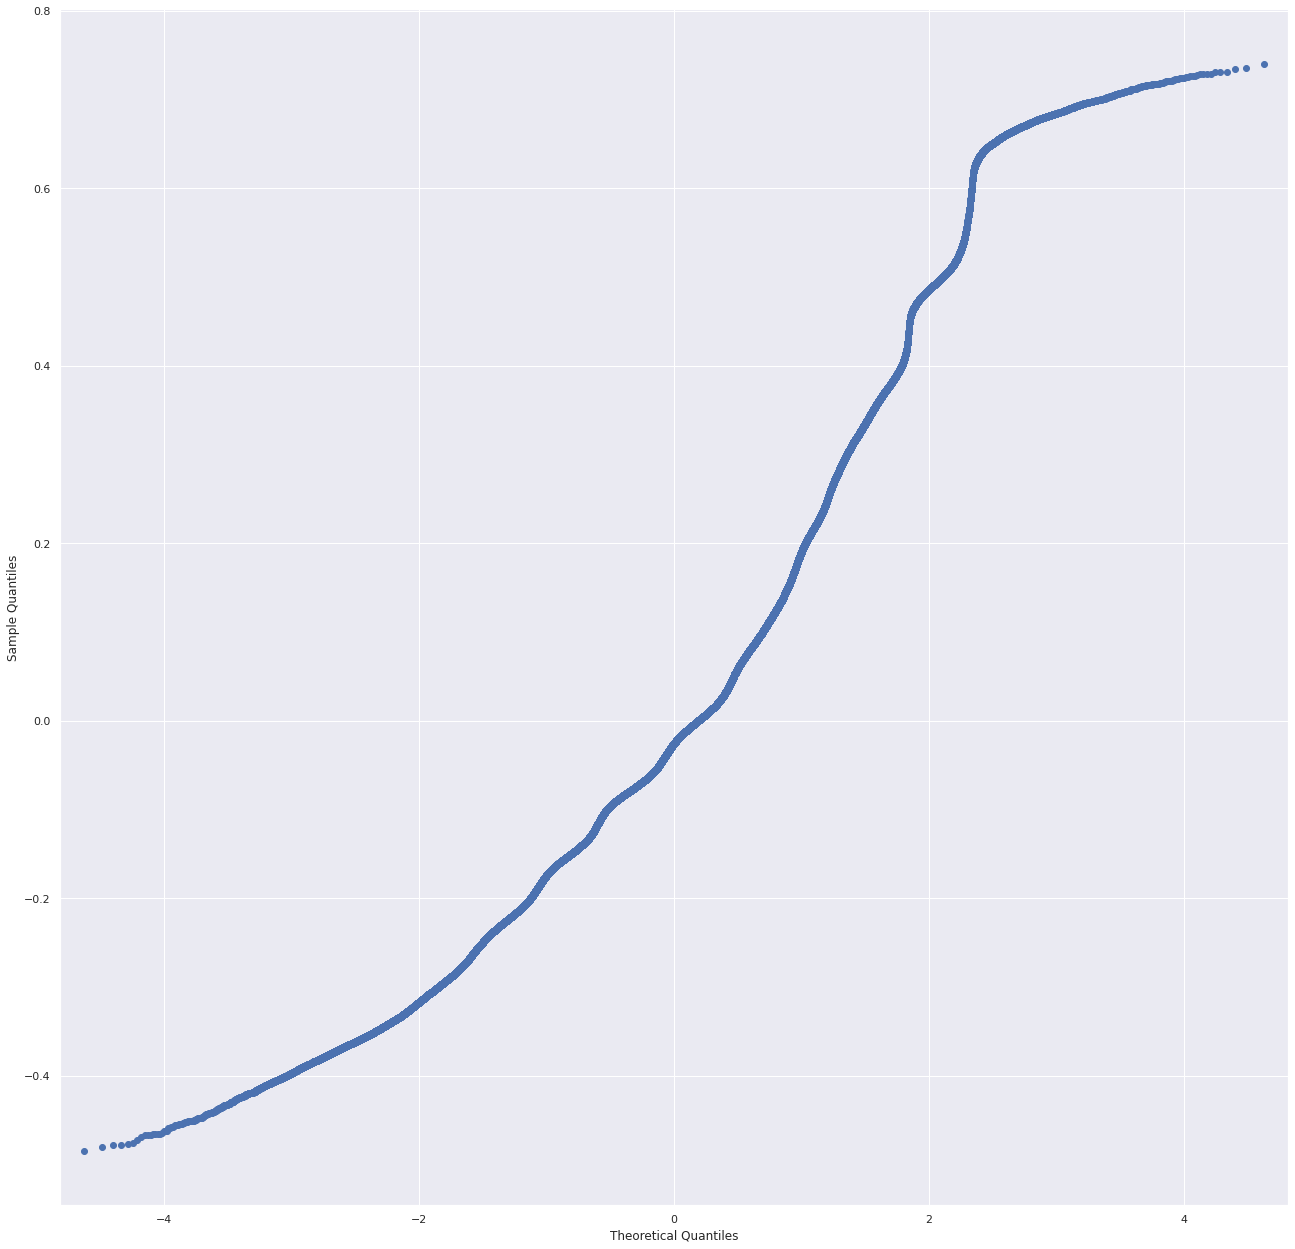

In [51]:
res = final_mlr_model.resid
sm.qqplot(res)
plt.show()

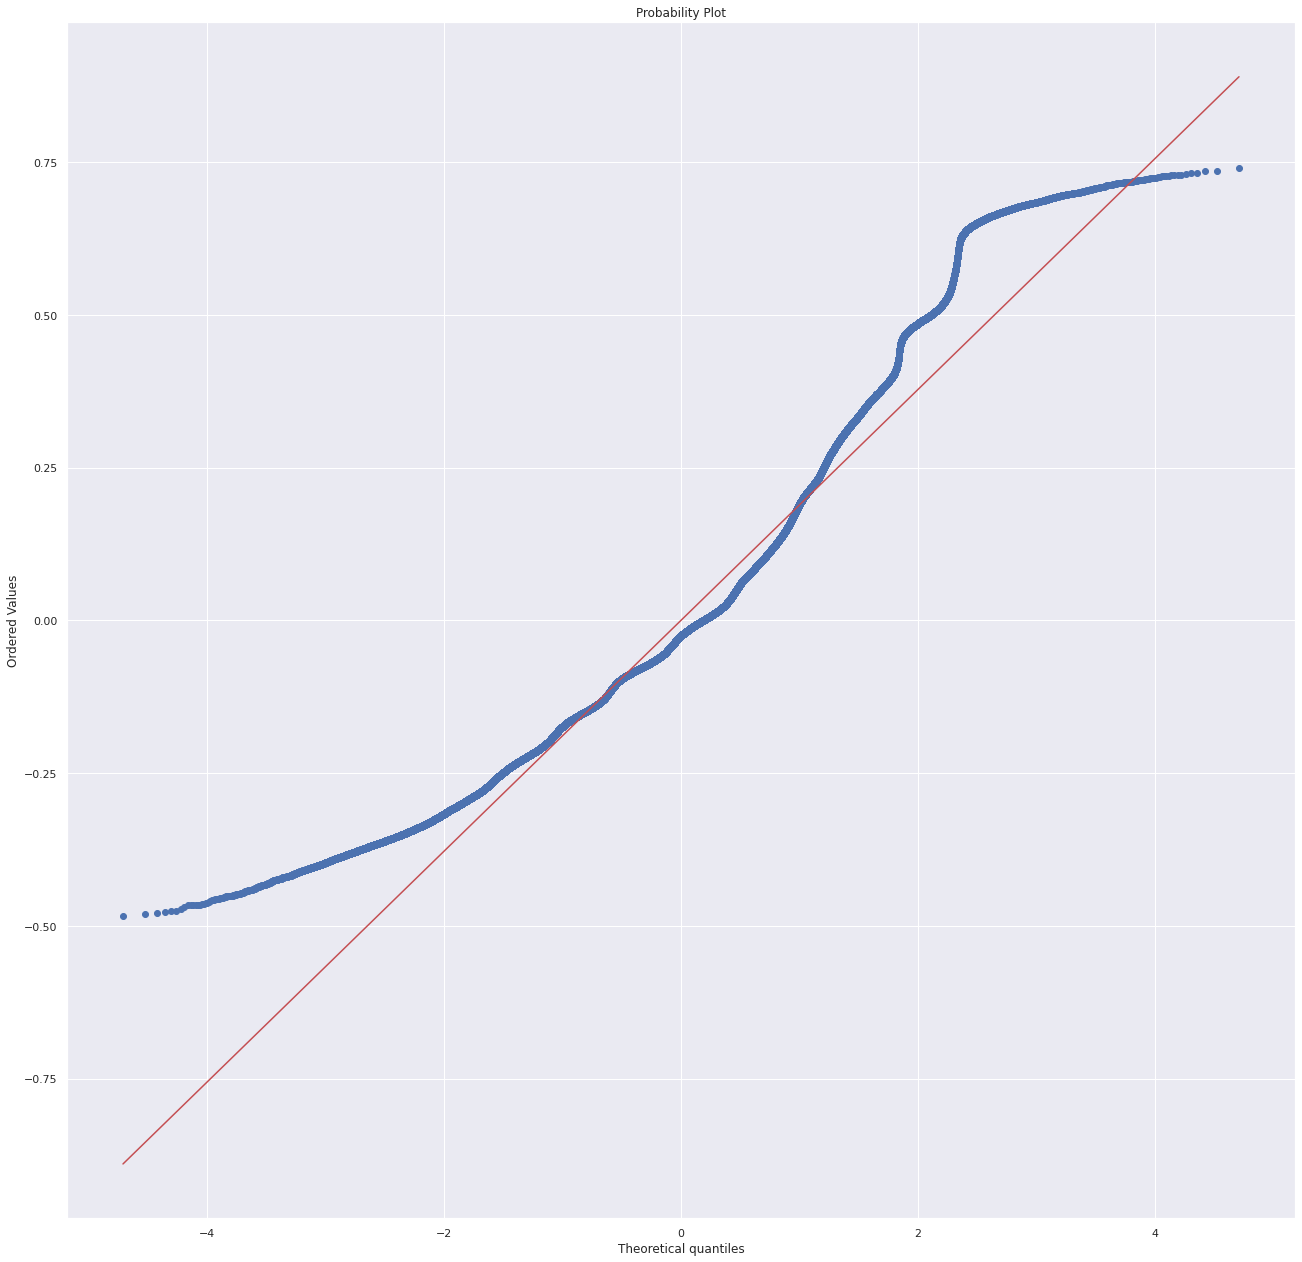

In [52]:
stats.probplot(res, dist = "norm", plot = pylab)
plt.show()


In [53]:
mlr_df_train, mlr_df_test = train_test_split(mlr_model_df, shuffle=True,test_size = 0.2)

In [54]:
mlr_model_train = smf.ols('Purchase ~ Gender + Age + Occupation + City_Category + Stay_In_Current_City_Years + Marital_Status + Product_Category_1 + Product_Category_2 + Product_Category_3', data = mlr_df_train).fit()


In [55]:
mlr_test_pred = mlr_model_train.predict(mlr_df_test)


In [56]:
test_resid =mlr_df_test.Purchase-mlr_test_pred
# RMSE value for test data 
test_rmse = np.sqrt(np.mean(test_resid * test_resid))
test_rmse

0.19360497220868927

In [57]:
mlr_train_pred = mlr_model_train.predict(mlr_df_train)

In [58]:
train_resid  = mlr_train_pred - mlr_df_train.Purchase
# RMSE value for train data 
train_rmse = np.sqrt(np.mean(train_resid * train_resid))
train_rmse

0.1930000326442945

In [59]:
100-0.19312811402149951

99.8068718859785

Create dfs split by age

In [60]:
mlr_model_df_nn.Age.value_counts()

2    219587
3    110013
1     99660
4     45701
5     38501
6     21504
0     15102
Name: Age, dtype: int64

In [61]:
age_group=mlr_model_df_nn.groupby('Age')

'0-17':0,'18-25':1,'26-35':2,'36-45':3,'46-50':4,'51-55':5,'55+':6

In [62]:
age0=age_group.get_group(0)

In [63]:
age1=age_group.get_group(1)

In [64]:
age2=age_group.get_group(2)

In [65]:
age3=age_group.get_group(3)

In [66]:
age4=age_group.get_group(4)

In [67]:
age5=age_group.get_group(5)

In [68]:
age6=age_group.get_group(6)

In [69]:
agedf_list=[age0,age1,age2,age3,age4,age5,age6]

In [70]:
for i in agedf_list:
  i.pop('Age')
  i=pd.DataFrame(nm.fit_transform(i))
  i.columns=['Gender', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase']
  i

In [71]:
age_summary=[]
for i in range(len(agedf_list)):
  mlr_age= smf.ols('Purchase ~ Gender + Occupation + City_Category + Stay_In_Current_City_Years + Marital_Status + Product_Category_1 + Product_Category_2 + Product_Category_3', data = agedf_list[i]).fit() # regression model
  print('Age range: ',i,'\n','Summary',mlr_age.summary())


Age range:  0 
 Summary                             OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     357.6
Date:                Fri, 19 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:58:25   Log-Likelihood:            -1.4923e+05
No. Observations:               15102   AIC:                         2.985e+05
Df Residuals:                   15094   BIC:                         2.985e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

### **ANN Model**

In [72]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [73]:
annDf = mlr_model_df.copy()

In [74]:
annDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  float64
 1   Age                         550068 non-null  float64
 2   Occupation                  550068 non-null  float64
 3   City_Category               550068 non-null  float64
 4   Stay_In_Current_City_Years  550068 non-null  float64
 5   Marital_Status              550068 non-null  float64
 6   Product_Category_1          550068 non-null  float64
 7   Product_Category_2          550068 non-null  float64
 8   Product_Category_3          550068 non-null  float64
 9   Purchase                    550068 non-null  float64
dtypes: float64(10)
memory usage: 42.0 MB


In [75]:
from tensorflow.keras.layers import Dropout

In [76]:
from tensorflow.keras.optimizers import Adam

In [101]:
annModel = keras.Sequential()

#
annModel.add(keras.layers.Dense(9, activation="relu"))
#annModel.add(keras.layers.Dense(1000, activation="relu"))
#annModel.add(keras.layers.Dense(610, activation="relu"))
#annModel.add(keras.layers.Dense(220, activation="relu"))
annModel.add(keras.layers.Dense(16, activation="relu"))
annModel.add(Dropout(0.2))
annModel.add(keras.layers.Dense(8, activation="relu"))
annModel.add(keras.layers.Dense(1, activation="linear"))

In [102]:
from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=0.1, momentum=0.9)
annModel.compile(loss="mean_squared_error",
              optimizer="Adam",
              metrics=["mse"])

In [79]:
#annModel.summary()

ValueError: ignored

In [80]:
from sklearn.model_selection import train_test_split

In [103]:
target = annDf["Purchase"]
train = annDf.drop(columns = "Purchase")

In [104]:
x_train,x_test,y_train,y_test = train_test_split(train,target,test_size=0.2,shuffle=True,random_state=14)

In [ ]:
#annTrain, annTest = train_test_split(annDf, test_size=.30, random_state=42)

In [ ]:
#trainTarger = annTrain.Purchase

In [ ]:
#annTrain.drop(columns = 'Purchase', inplace=True)

In [ ]:
#testTarget = annTest.Purchase

In [ ]:
a#nnTest.drop(columns = 'Purchase', inplace=True)

In [ ]:
# "annxTrain, annxTest, annyTrain, annyTest = train_test_split(annDf.iloc[:,:-1], annDf.Purchase, test_size=.30, random_state=42)
#print(annTrain.shape)
#print(trainTarger.shape) 
#print(annTest.shape) 
#print(testTarget.shape)

In [105]:
# annModelHistory = annModel.fit(annTrain, trainTarger, epochs=3, validation_data=(annTest,testTarget))
annModelHistory = annModel.fit(x_train, y_train, batch_size=128,epochs=20)

Epoch 1/20
3438/3438 [==============================] - 15s 4ms/step - loss: 0.0354 - mse: 0.0354
Epoch 2/20
3438/3438 [==============================] - 9s 2ms/step - loss: 0.0313 - mse: 0.0313
Epoch 3/20
3438/3438 [==============================] - 6s 2ms/step - loss: 0.0299 - mse: 0.0299
Epoch 4/20
3438/3438 [==============================] - 6s 2ms/step - loss: 0.0291 - mse: 0.0291
Epoch 5/20
3438/3438 [==============================] - 6s 2ms/step - loss: 0.0286 - mse: 0.0286
Epoch 6/20
3438/3438 [==============================] - 6s 2ms/step - loss: 0.0279 - mse: 0.0279
Epoch 7/20
3438/3438 [==============================] - 6s 2ms/step - loss: 0.0272 - mse: 0.0272
Epoch 8/20
3438/3438 [==============================] - 6s 2ms/step - loss: 0.0268 - mse: 0.0268
Epoch 9/20
3438/3438 [==============================] - 6s 2ms/step - loss: 0.0265 - mse: 0.0265
Epoch 10/20
3438/3438 [==============================] - 6s 2ms/step - loss: 0.0263 - mse: 0.0263
Epoch 11/20
3438/3438 [=====

In [84]:
from sklearn.metrics import r2_score

In [85]:
pred=annModel.predict(x_test)

In [86]:
print(pred)

[[0.3149293 ]
 [0.27721083]
 [0.6879658 ]
 ...
 [0.2600529 ]
 [0.27905965]
 [0.24860665]]


In [87]:
r2_score(y_test, pred)

0.6260757492075798

In [89]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



In [96]:
X = reduce_mem_usage(x_train)
y= y_train

Mem. usage decreased to 10.91 Mb (0.0% reduction)


In [91]:
model = lgb.LGBMRegressor()

In [92]:
model.fit(X,y_train)

LGBMRegressor()

In [94]:
x_pred = model.predict(x_test)
r2_score(y_test,x_pred)

0.6676031306973145